# WiFi Channel State Information (CSI) example

Necessary imports.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import ctypes

This function, given raw CSI values will return the complex CSI values alongside the RSS and time stampes

In [7]:
def binary_to_complex(collector: dict):
    if len(collector.keys()) == 0:
        return (None, None, None)
    subcarriers_num = (len(collector[list(collector.keys())[0]]) - 18) // 4 # 18 is the number of bytes in leading information & each subcarrier has 4 bytes

    complex_csi = np.zeros((len(collector), subcarriers_num), dtype=complex)
    RSS = np.zeros((len(collector), 1), dtype=np.int8)
    row = 0
    for time, packet in collector.items():
        magic_bytes = packet[0:2].hex()
        rssi = packet[2:3].hex()
        rssi = ctypes.c_int8(int(rssi, 16)).value
        frame_control = packet[3:4].hex()
        source_mac = packet[4:10].hex()
        sequence_number = packet[10:12].hex()
        core_spatial = packet[12:14].hex()
        chanspec = packet[14:16].hex()
        chip_version = packet[16:18].hex()
        csi = packet[18:]
        complex_csi[row] = np.array([complex(int.from_bytes(csi[start:start+2], 'little', signed=True), int.from_bytes(csi[start+2:start+4], 'little', signed=True)) for start in range(0, 1024, 4)], dtype=complex)
        RSS[row] = rssi
        row += 1
        
    time_stamp_ns = np.array(list(collector.keys()))
    time_stamp_ns = time_stamp_ns - time_stamp_ns[0]
    
    return (time_stamp_ns, complex_csi, RSS)

This function will plot the complex CSI values in a given ax.

In [8]:
def plot_complex_csi(ax, time_stamp_ns: np.ndarray, complex_csi: np.ndarray, max=3000, title='CSI'):
    amp = abs(complex_csi)
    num_of_subcarriers = amp.shape[1]
    if num_of_subcarriers == 256: # 80 Mhz collection
        amp = np.delete(amp, [0, 1, 2, 3, 4, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 253, 254, 255], axis=1)
    else:
        print(f"WARNING: pilot and unused subcarrier removal is not implemented for {num_of_subcarriers} subcarriers, using thresholding instead ...")
        amp[amp >= max] = 0
    
    places = np.round(np.linspace(0, len(time_stamp_ns) - 1, 15)).astype(int)
    ax.set_xticks(places, (time_stamp_ns[places]/1e09).astype(int), rotation='horizontal', fontsize=16, fontweight='regular') # in case you want to plot w.r.t time[s]
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
    cax = ax.imshow(amp.T, interpolation="nearest", aspect="auto")
    ax.figure.colorbar(cax, ax=ax, orientation="vertical", pad=0.01, location='right')
    ax.set_title(title)
    ax.set_xlabel("time (s)", fontsize=18, fontweight='regular')# in case you want to plot w.r.t time[s]
    ax.set_ylabel("subcarrier", fontsize=18, fontweight='regular')

Put a `csi.dat` file alongside this notebook directory and specify the `file_name` variable.

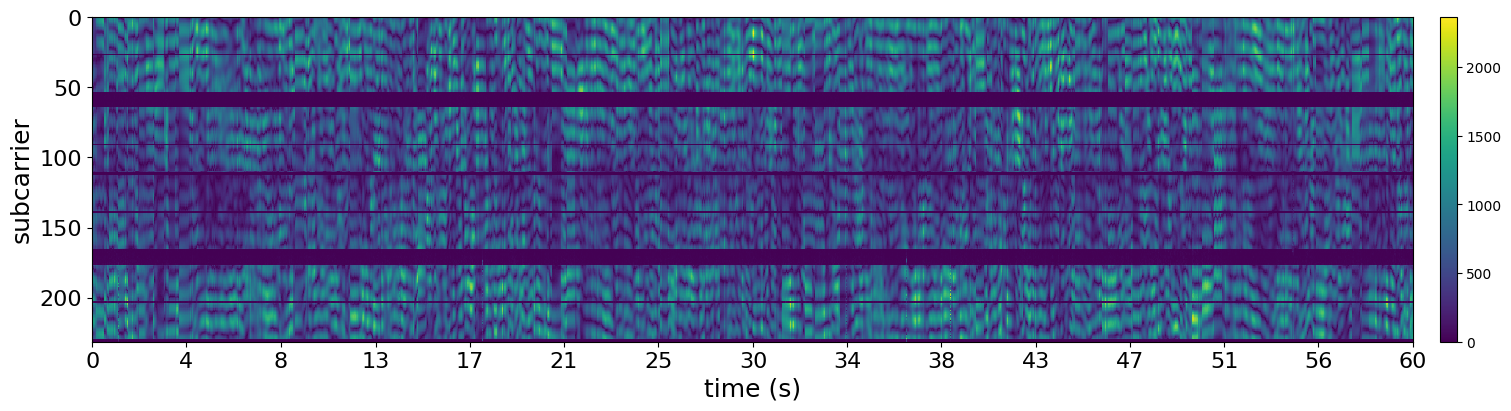

In [9]:
file_name = "18_10_2024_15_40_28_csi.dat"

pickle_in = open(file_name, "rb")
collectors = pickle.load(pickle_in)
pickle_in.close()

# save all sniffers ip and data in a list
collector_complex = []
for collector_ip, collector in collectors.items():
    time_stamp_ns, complex_csi, RSS = binary_to_complex(collector)
    if type(time_stamp_ns) == type(None):
        print("bad file:", file_name)
        raise Exception("bad file format")
    collector_complex.append({"collector_ip": collector_ip, "time_stamp_ns": time_stamp_ns, "complex_csi": complex_csi, "RSS": RSS})



fig, axes = plt.subplots(nrows=len(collector_complex), ncols=1, figsize=(15, 4), constrained_layout=True)
if len(collector_complex) == 1:
    axes = [axes]

for i, csi in enumerate(collector_complex):
    ax = axes[i]
    plot_complex_csi(ax, csi['time_stamp_ns'], csi['complex_csi'], max=3000, title="")
